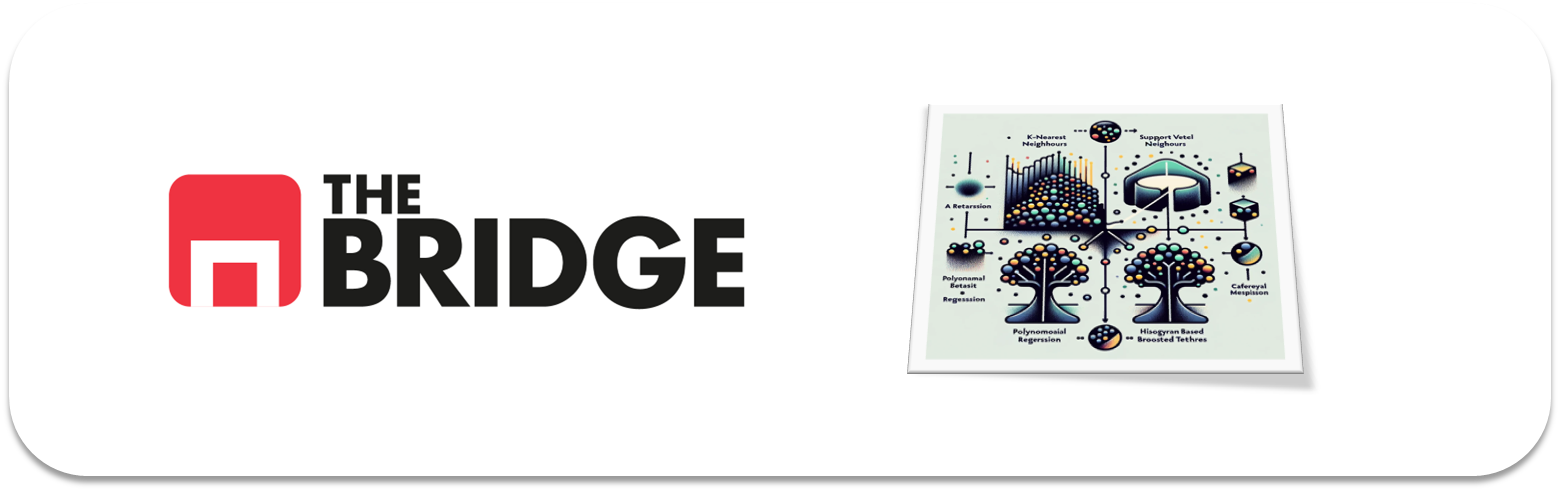

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from xgboost import XGBClassifier


### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

Sacado de github y traducido en chatgpt

1. **SeriousDlqin2yrs**: Variable dependiente/binaria. Indica si el individuo experimentó morosidad de 90 días o más en los próximos dos años al momento de la toma de datos. Un valor de 1 indica que sí experimentó dificultades financieras serias, y 0 en caso contrario.

2. **RevolvingUtilizationOfUnsecuredLines**: Proporción del crédito utilizado por el consumidor en relación con todas sus líneas de crédito disponibles sin garantía (como tarjetas de crédito).

3. **age**: Edad del prestatario en años.

4. **NumberOfTime30-59DaysPastDueNotWorse**: Número de veces que el prestatario ha estado retrasado entre 30 y 59 días en sus pagos, pero no peor en los últimos 2 años.

5. **DebtRatio**: Relación deuda/ingreso. Es una medida de la carga de deuda del prestatario, calculada como sus pagos mensuales de deuda divididos por su ingreso mensual.

6. **MonthlyIncome**: Ingreso mensual del prestatario.

7. **NumberOfOpenCreditLinesAndLoans**: Número de préstamos abiertos y líneas de crédito (como préstamos para automóviles, hipotecas, préstamos personales, etc.).

8. **NumberOfTimes90DaysLate**: Número de veces que el prestatario ha estado retrasado más de 90 días en sus pagos.

9. **NumberRealEstateLoansOrLines**: Número de préstamos o líneas de crédito inmobiliarios, incluyendo hipotecas y líneas de crédito con garantía hipotecaria.

10. **NumberOfTime60-89DaysPastDueNotWorse**: Número de veces que el prestatario ha estado retrasado entre 60 y 89 días en sus pagos, pero no peor en los últimos 2 años.

11. **NumberOfDependents**: Número de dependientes que el prestatario tiene en su familia, excluyéndose a sí mismo.


In [2]:
df = pd.read_csv("./data/credit_npo.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Es un problema de clasificacion binaria

y la variable target es la primera, serious DLqi2Yrs

### #1.3
Pinta la distribución de frecuencias del target y coméntala

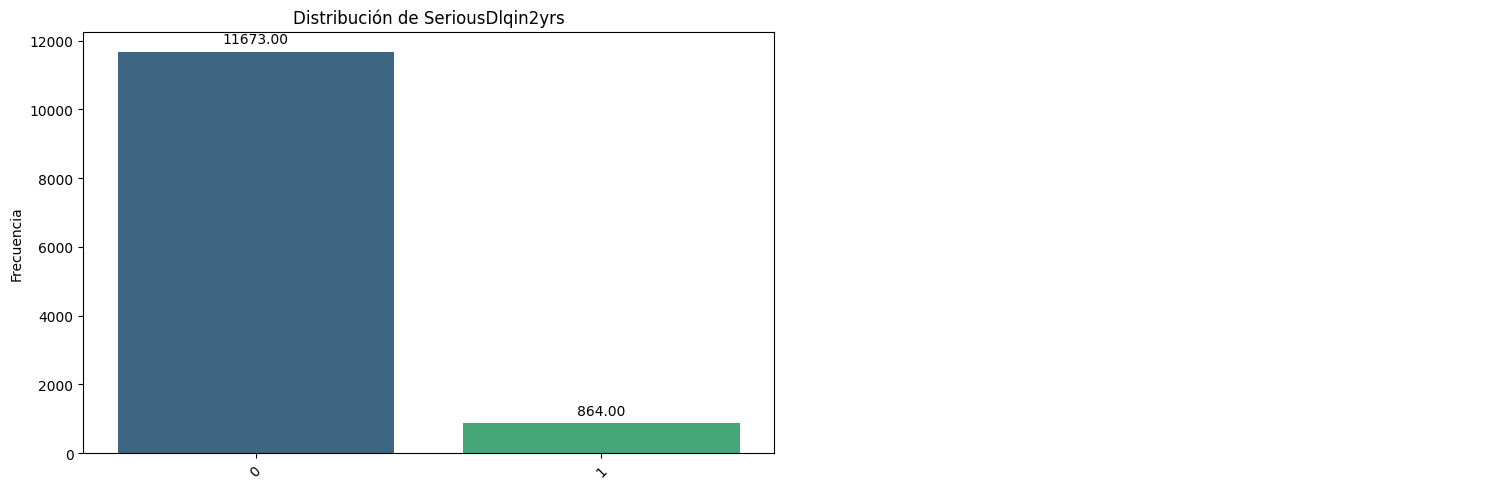

In [4]:
target = "SeriousDlqin2yrs"

bt.pinta_distribucion_categoricas(df,[target], mostrar_valores= True)

In [6]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

In [9]:
moda_train = train_set["NumberOfDependents"].mode()
print(moda_train)

0    0.0
Name: NumberOfDependents, dtype: float64


In [10]:
moda_train = moda_train[0] # lo convierto en un valor (antes era un serie de pandas)
train_set["NumberOfDependents"] = train_set["NumberOfDependents"].fillna(moda_train)
test_set["NumberOfDependents"] = test_set["NumberOfDependents"].fillna(moda_train)


mediana = train_set["MonthlyIncome"].quantile(0.5)
train_set["MonthlyIncome"] = train_set["MonthlyIncome"].fillna(mediana)
test_set["MonthlyIncome"] = test_set["MonthlyIncome"].fillna(mediana)

In [11]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10029 entries, 5441 to 7270
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      10029 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  10029 non-null  float64
 2   age                                   10029 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  10029 non-null  int64  
 4   DebtRatio                             10029 non-null  float64
 5   MonthlyIncome                         10029 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       10029 non-null  int64  
 7   NumberOfTimes90DaysLate               10029 non-null  int64  
 8   NumberRealEstateLoansOrLines          10029 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  10029 non-null  int64  
 10  NumberOfDependents                    10029 non-null  float64
dtypes: float64(4), int

El target esta desbalanceado o desequilibrado.

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

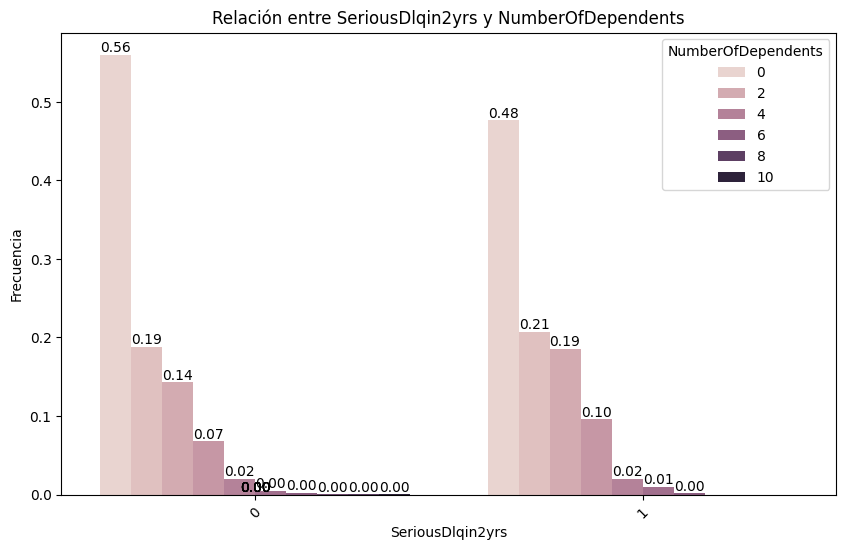

In [52]:
bt.plot_categorical_relationship_fin(train_set, target, "NumberOfDependents", show_values= True, relative_freq= True)

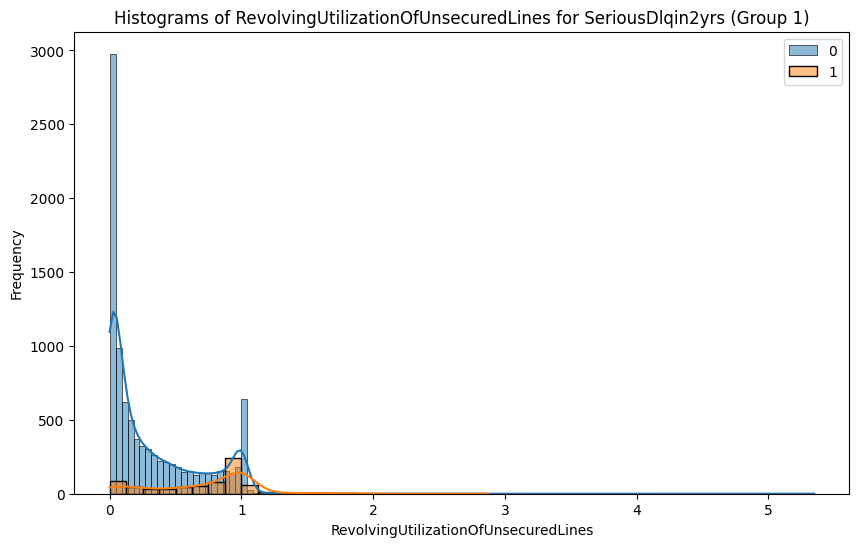

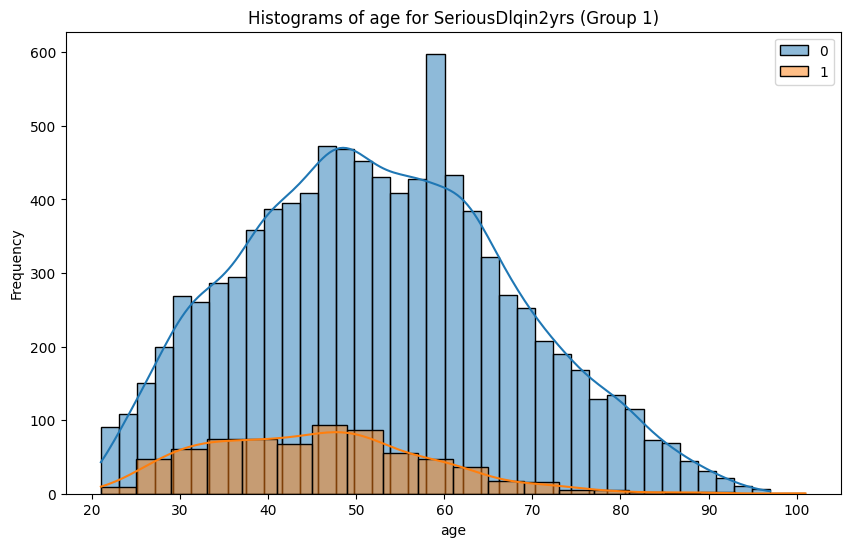

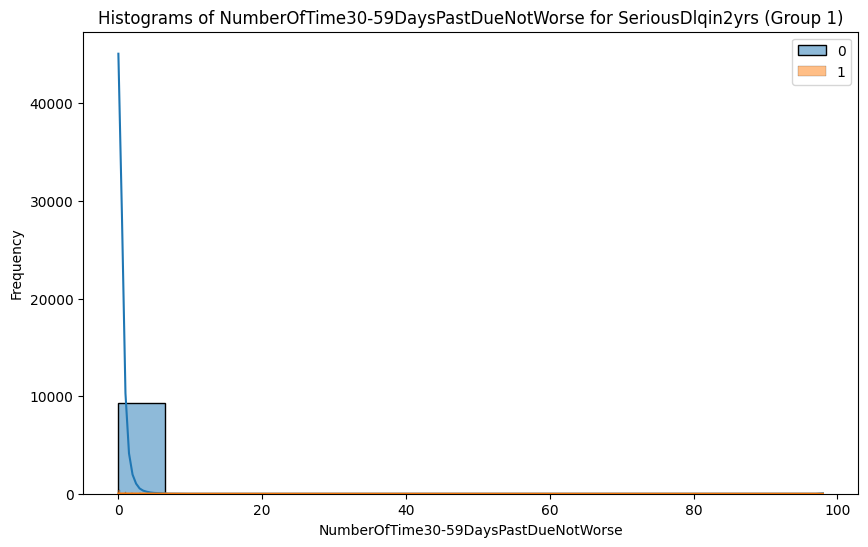

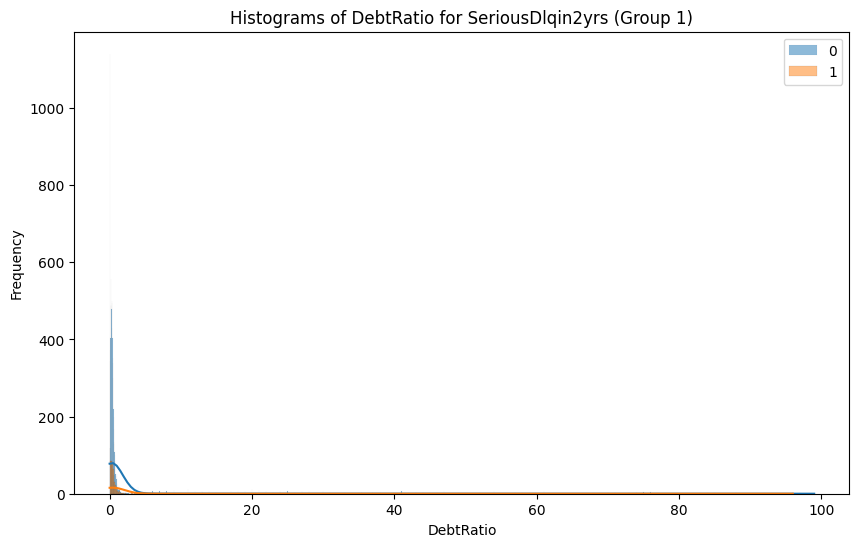

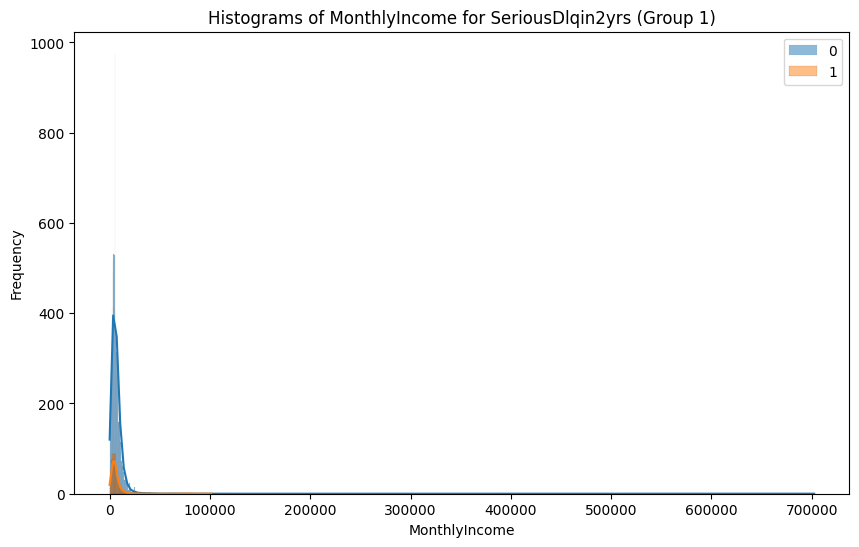

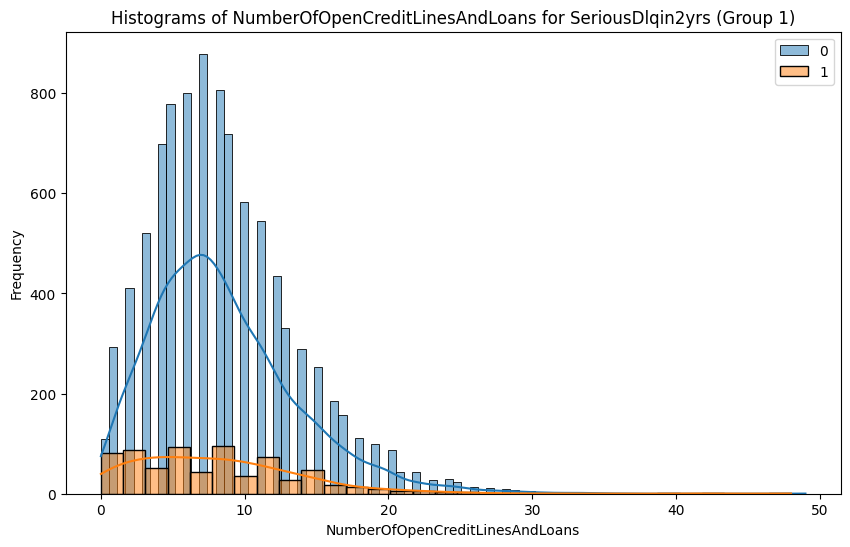

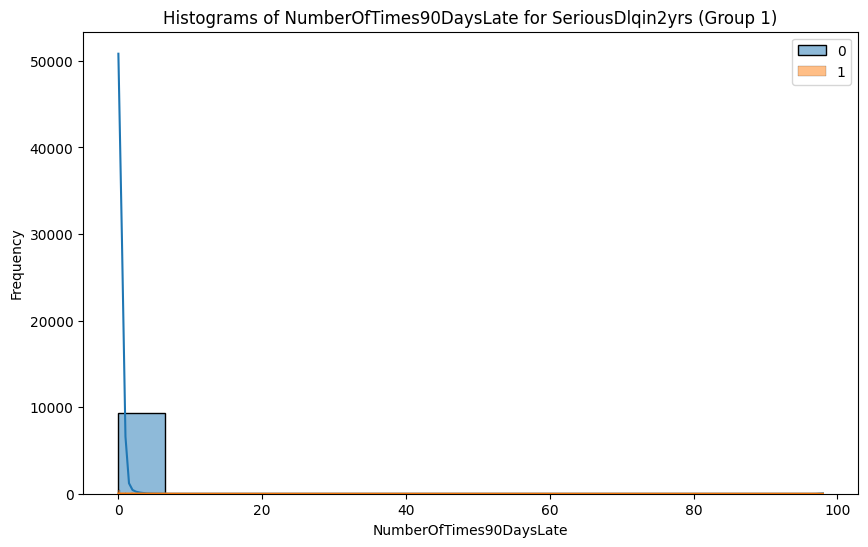

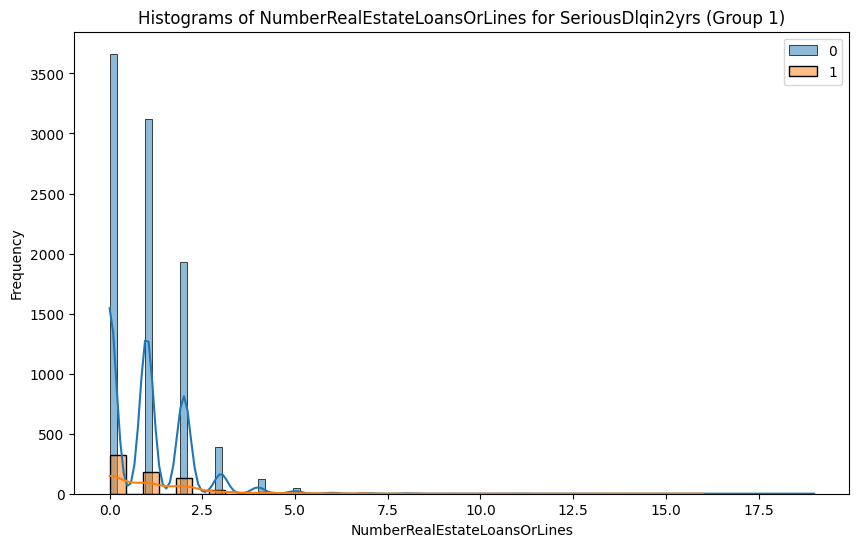

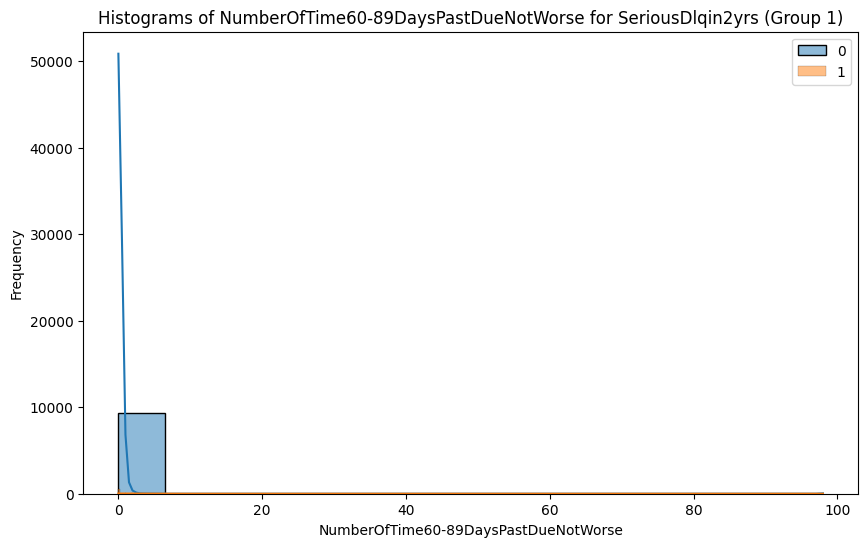

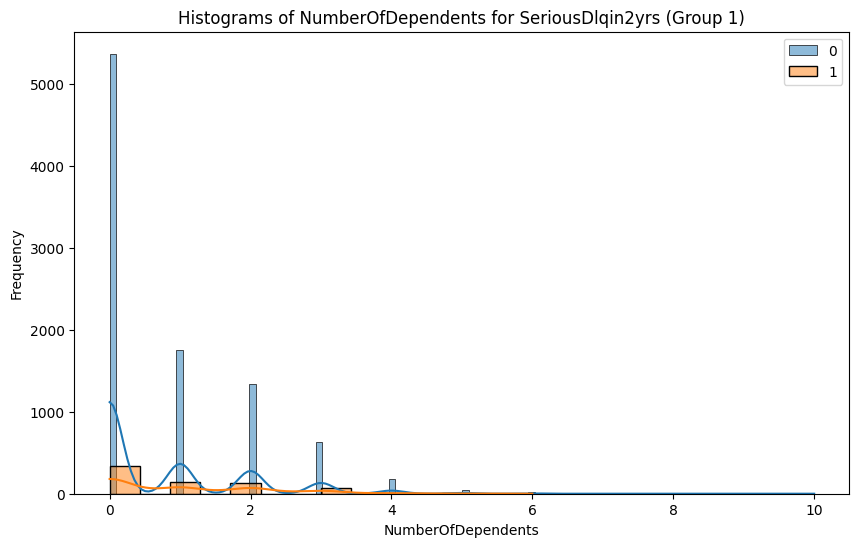

In [16]:
features = [col for col in train_set.columns if col != target]
for col in features:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col= col, group_size= 2)

. Me quedo con todas hasta ahora

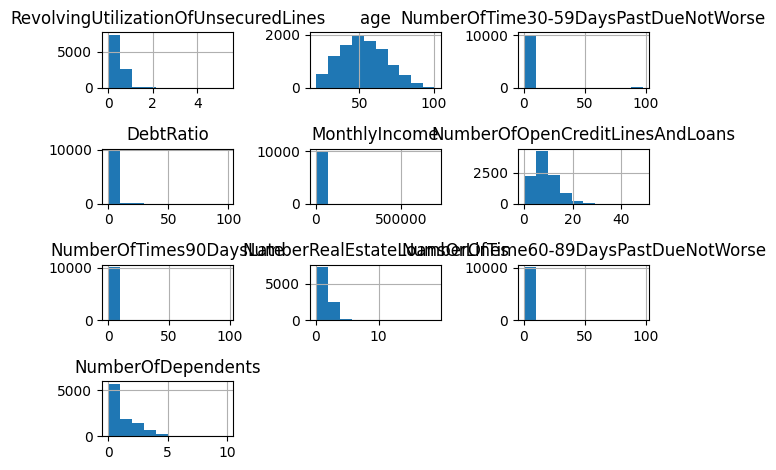

In [17]:
train_set[features].hist()
plt.tight_layout()

Hago transformacion de todas las columnas menos la de age que parece estar normal. 

In [18]:
train_set_2 = train_set.copy()
test_set_2 = test_set.copy()

In [19]:
for col in features:
    if col != "age":
        train_set_2[col] = np.log(train_set_2[col] + 1) 
        test_set_2[col] = np.log(test_set_2[col] + 1) 

In [20]:
scaler = StandardScaler()
train_set_2[features] = scaler.fit_transform(train_set_2[features])
test_set_2[features] = scaler.transform(test_set_2[features])

In [21]:
X_train = train_set[features]
X_train_2 = train_set_2[features]
y_train = train_set[target]

X_test = test_set[features]
X_test_2 = test_set_2[features]
y_test = test_set[target]


In [22]:
X_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10029 entries, 5441 to 7270
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RevolvingUtilizationOfUnsecuredLines  10029 non-null  float64
 1   age                                   10029 non-null  float64
 2   NumberOfTime30-59DaysPastDueNotWorse  10029 non-null  float64
 3   DebtRatio                             10029 non-null  float64
 4   MonthlyIncome                         10029 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       10029 non-null  float64
 6   NumberOfTimes90DaysLate               10029 non-null  float64
 7   NumberRealEstateLoansOrLines          10029 non-null  float64
 8   NumberOfTime60-89DaysPastDueNotWorse  10029 non-null  float64
 9   NumberOfDependents                    10029 non-null  float64
dtypes: float64(10)
memory usage: 861.9 KB


In [23]:
# KNN 

knn_clf = KNeighborsClassifier(n_neighbors= 7)
knn_clf.fit(X_train_2, y_train)

KNeighborsClassifier(n_neighbors=7)

In [25]:
print(classification_report(y_train, knn_clf.predict(X_train_2)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9328
           1       0.71      0.27      0.39       701

    accuracy                           0.94     10029
   macro avg       0.83      0.63      0.68     10029
weighted avg       0.93      0.94      0.93     10029



In [30]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote_scaled, y_train_smote_scaled = smote.fit_resample(X_train_2, y_train) 


In [31]:



modelos = ["KNN","Logistic","RandomF","XGBoost","LightGBM"]
metricas = []
lr_clf = LogisticRegression(max_iter = 10000)
rf_clf = RandomForestClassifier(max_depth = 5, random_state = 42)
xgb_clf = XGBClassifier(max_depth = 5, random_state = 42)
lgb_clf = LGBMClassifier(max_depth= 5, verbose = -100, random_state = 42)
model = []

for nombre,modelo in zip(modelos,[knn_clf, lr_clf, rf_clf, xgb_clf, lgb_clf]):
    model.append(modelo)
    print(f"Para {nombre}:", end = " ")
    if nombre not in modelos[0:2]:
        metrica = np.mean(cross_val_score(modelo, X_train_smote, y_train_smote, cv = 5, scoring = "balanced_accuracy"))
    else:
        metrica = np.mean(cross_val_score(modelo, X_train_smote_scaled, y_train_smote_scaled, cv = 5, scoring = "balanced_accuracy"))
        #metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring = "balanced_accuracy"))
    print(metrica)
    metricas.append(metrica)

Para KNN: 0.8954758353950616
Para Logistic: 0.7818395788614663
Para RandomF: 0.8203808809542282
Para XGBoost: 0.9157413745046824
Para LightGBM: 0.9011614642150059
